#### Import my dataset

In [47]:
from pre_processing_py import HandScanDataset2, transform, validation_transform, train_df, valid_df, training_data_dir, display_images
from timm.models.layers import DropPath, trunc_normal_
import numpy as np


In [48]:
!pip install einops


In [49]:
pip install tensorboard


Note: you may need to restart the kernel to use updated packages.


Define the swinTransformer blocks

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint
from einops import rearrange
from functools import reduce
from operator import mul

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x




In [51]:
class WindowAttention3D(nn.Module):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # Correct the relative position bias table
        num_rel_positions = (2 * window_size[0] - 1) * (2 * window_size[1] - 1) * (2 * window_size[2] - 1)
        self.relative_position_bias_table = nn.Parameter(torch.zeros(num_rel_positions, num_heads))

        # Calculate the relative position index for the given window size
        coords_d = torch.arange(self.window_size[0])
        coords_h = torch.arange(self.window_size[1])
        coords_w = torch.arange(self.window_size[2])
        coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w, indexing='ij'))  # Adjust for new torch versions
        coords_flatten = torch.flatten(coords, 1)  # Flatten to [3, Wd*Wh*Ww]
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # Compute relative positions
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # [Wd*Wh*Ww, Wd*Wh*Ww, 3]

        # Convert relative coordinates to indices in the bias table
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 2] += self.window_size[2] - 1
        relative_coords[:, :, 0] *= (2 * self.window_size[1] - 1) * (2 * self.window_size[2] - 1)
        relative_coords[:, :, 1] *= 2 * self.window_size[2] - 1
        relative_position_index = relative_coords.sum(-1)  # [Wd*Wh*Ww, Wd*Wh*Ww]

        self.register_buffer("relative_position_index", relative_position_index)

        # Define layers
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        B_, N, C = x.shape

        # Generate Q, K, V matrices
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Compute attention scores
        q = q * self.scale
        attn = q @ k.transpose(-2, -1)

        # Apply relative position bias correctly
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            N, N, -1)  # Ensure N matches the token size
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)

        attn = self.softmax(attn)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


In [52]:
import torch.nn as nn
from monai.networks.blocks import UnetBasicBlock

class PatchEmbed3D(nn.Module):
    """Video to Patch Embedding.

    Args:
        patch_size (int): Patch token size. Default: (4, 4, 4).
        in_chans (int): Number of input video channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, patch_size=(4, 4, 4), in_chans=1, embed_dim=512, norm_layer=None):
        super().__init__()
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim

        # Using MONAI's UnetBasicBlock for projection
        self.proj = UnetBasicBlock(
            spatial_dims=3,
            in_channels=in_chans,
            out_channels=embed_dim,
            kernel_size=3,
            stride=2,
            norm_name=("INSTANCE", {"affine": True}),
        )

    def forward(self, x):
        """Forward function."""
        print(f"Input shape: {x.shape}")
        
        x = self.proj(x)  # B C D Wh Ww
        
        print(f"Shape after UnetBasicBlock projection: {x.shape}")
        
        return x


### WindowPartition and WindowReverse Functions

In [53]:
from functools import reduce
from operator import mul

def window_partition(x, window_size):
    """
    Args:
        x: (B, D, H, W, C)
        window_size (tuple[int]): window size

    Returns:
        windows: (B*num_windows, window_size*window_size, C)
    """
    print(f"This Input shape: {x.shape}")
    
    B, D, H, W, C = x.shape
    print(f"B: {B}")
    print(f"C: {C}")
    print(f"D: {D}")
    print(f"H: {H}")
    print(f"W: {W}")

    
    x = x.view(
        B,
        D // window_size[0],
        window_size[0],
        H // window_size[1],
        window_size[1],
        W // window_size[2],
        window_size[2],
        C,
    )
    
    print(f"Shape after view operation: {x.shape}")
    
    windows = x.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous().view(-1, reduce(mul, window_size), C)
    print(f"Shape after permute and final view: {windows.shape}")
    
    return windows





In [54]:
def window_reverse(windows, window_size, B, D, H, W):
    """
    Args:
        windows: (B*num_windows, window_size[0]*window_size[1]*window_size[2], C)
        window_size (tuple[int]): Window size
        B (int): Batch size
        D (int): Depth
        H (int): Height
        W (int): Width

    Returns:
        x: (B, D, H, W, C)
    """
    # Reverse the reshape operation
    x = windows.view(B, D // window_size[0], H // window_size[1], W // window_size[2],
                     window_size[0], window_size[1], window_size[2], -1)
    x = x.permute(0, 1, 4, 2, 5, 3, 6, 7).contiguous().view(B, D, H, W, -1)
    print(f"Shape after reversing windows: {x.shape}")  # Debugging
    return x

### get_window_size Function
This function adjusts the window size according to the input size.

In [55]:
def get_window_size(x_size, window_size, shift_size=None):
    print(f"Input x_size: {x_size}")
    print(f"Initial window_size: {window_size}")
    print(f"Initial shift_size: {shift_size}")

    use_window_size = list(window_size)
    if shift_size is not None:
        use_shift_size = list(shift_size)
    
    for i in range(len(x_size)):
        if x_size[i] < window_size[i]:
            print(f"Adjusting window_size[{i}] from {window_size[i]} to {x_size[i]} because x_size[{i}] <= window_size[{i}]")
            use_window_size[i] = x_size[i]
            if shift_size is not None:
                print(f"Setting shift_size[{i}] to 0 because x_size[{i}] <= window_size[{i}]")
                use_shift_size[i] = 0

    if shift_size is None:
        print(f"Final use_window_size: {tuple(use_window_size)}")
        return tuple(use_window_size)
    else:
        print(f"Final use_window_size: {tuple(use_window_size)}, use_shift_size: {tuple(use_shift_size)}")
        return tuple(use_window_size), tuple(use_shift_size)


### compute_mask Function
This function computes the attention mask for the shifted windows.

In [56]:
import torch

def compute_mask(D, H, W, window_size, shift_size, device):
    print(f"Dimensions (D, H, W): ({D}, {H}, {W})")
    print(f"Window size: {window_size}")
    print(f"Shift size: {shift_size}")

    img_mask = torch.zeros((1, D, H, W, 1), device=device)  # 1 Dp Hp Wp 1
    print(f"Initial img_mask shape: {img_mask.shape}")

    cnt = 0
    for d in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
        for h in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
            for w in slice(-window_size[2]), slice(-window_size[2], -shift_size[2]), slice(-shift_size[2], None):
                print(f"Filling img_mask with cnt={cnt} for slices d={d}, h={h}, w={w}")
                img_mask[:, d, h, w, :] = cnt
                cnt += 1

    print(f"img_mask after filling: {img_mask.unique()}")  # Shows the unique values in the mask

    mask_windows = window_partition(img_mask, window_size)  # nW, ws[0]*ws[1]*ws[2], 1
    print(f"mask_windows shape after partitioning: {mask_windows.shape}")

    mask_windows = mask_windows.squeeze(-1)  # nW, ws[0]*ws[1]*ws[2]
    print(f"mask_windows shape after squeezing: {mask_windows.shape}")

    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    print(f"attn_mask shape after subtraction: {attn_mask.shape}")

    attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
    print(f"Final attn_mask shape: {attn_mask.shape}")

    return attn_mask


### PatchMerging Class
The PatchMerging class is used to downsample the spatial dimensions of the feature maps while increasing the channel dimension. 

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchMerging(nn.Module):
    """ Patch Merging Layer.

    Args:
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.reduction = nn.Linear(8 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(8 * dim)

    def forward(self, x):
        """
        Args:
            x: Input feature, tensor size (B, D, H, W, C).
        """
        # # print(f"Original input shape: {x.shape}")
        
        B, D, H, W, C = x.shape

        # Padding to handle odd dimensions
        pad_input = (H % 2 == 1) or (W % 2 == 1) or (D % 2 == 1)
        if pad_input:
            x = F.pad(x, (0, 0, 0, W % 2, 0, H % 2, 0, D % 2))
            print(f"Shape after padding: {x.shape}")

        # Splitting the input into 8 parts and concatenating them along the channel dimension
        x0 = x[:, 0::2, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, 0::2, :]
        x3 = x[:, 0::2, 0::2, 1::2, :]
        x4 = x[:, 1::2, 1::2, 0::2, :]
        x5 = x[:, 1::2, 0::2, 1::2, :]
        x6 = x[:, 0::2, 1::2, 1::2, :]
        x7 = x[:, 1::2, 1::2, 1::2, :]
        
        print(f"Shapes of split parts: {[x0.shape, x1.shape, x2.shape, x3.shape, x4.shape, x5.shape, x6.shape, x7.shape]}")

        x = torch.cat([x0, x1, x2, x3, x4, x5, x6, x7], -1)  # B D/2 H/2 W/2 8*C
        print(f"Shape after concatenation: {x.shape}")

        x = self.norm(x)
        print(f"Shape after normalization: {x.shape}")

        x = self.reduction(x)
        print(f"Shape after linear reduction: {x.shape}")

        return x



#### Build the Transformer Layers and Network

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SwinTransformerBlock3D(nn.Module):
    def __init__(self, dim, num_heads, window_size=(2, 16, 16), shift_size=(1, 8, 8), mlp_ratio=4.0, drop=0.0, attn_drop=0.0, drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention3D(
            dim=dim,
            window_size=window_size,
            num_heads=num_heads,
            qkv_bias=True,
            attn_drop=attn_drop,
            proj_drop=drop
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, out_features=dim, drop=drop)

    def forward(self, x, mask_matrix=None):
        B, D, H, W, C = x.shape
        window_size, shift_size = get_window_size((D, H, W), self.window_size, self.shift_size)
        x = self.norm1(x)
        pad_l = pad_t = pad_d0 = 0
        pad_d1 = (window_size[0] - D % window_size[0]) % window_size[0]
        pad_b = (window_size[1] - H % window_size[1]) % window_size[1]
        pad_r = (window_size[2] - W % window_size[2]) % window_size[2]
        x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b, pad_d0, pad_d1))
        _, Dp, Hp, Wp, _ = x.shape

        if any(i > 0 for i in shift_size):
            shifted_x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1], -shift_size[2]), dims=(1, 2, 3))
            attn_mask = mask_matrix
        else:
            shifted_x = x
            attn_mask = None

        x_windows = window_partition(shifted_x, window_size)  # B*nW, Wd*Wh*Ww, C
        attn_windows = self.attn(x_windows, mask=attn_mask)  # B*nW, Wd*Wh*Ww, C
        x_windows = attn_windows.view(-1, window_size[0], window_size[1], window_size[2], C)
        x = window_reverse(x_windows, window_size, B, Dp, Hp, Wp)

        if any(i > 0 for i in shift_size):
            x = torch.roll(x, shifts=(shift_size[0], shift_size[1], shift_size[2]), dims=(1, 2, 3))

        if pad_d1 > 0 or pad_r > 0 or pad_b > 0:
            x = x[:, :D, :H, :W, :].contiguous()

        x = x + self.drop_path(self.norm2(self.mlp(x)))
        return x



### BasicLayer Class
The BasicLayer class handles the core operations in the Swin Transformer for each stage.

In [59]:
import torch
import torch.nn as nn
from einops import rearrange
import numpy as np

class BasicLayer(nn.Module):
    def __init__(
        self,
        dim,
        depth,
        num_heads,
        window_size=(2, 14, 14),
        mlp_ratio=4.0,
        qkv_bias=False,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        norm_layer=nn.LayerNorm,
        downsample=None,
        use_checkpoint=False,
    ):
        super().__init__()
        self.window_size = window_size
        self.shift_size = tuple(i // 2 for i in window_size)
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        self.blocks = nn.ModuleList(
            [
                SwinTransformerBlock3D(
                    dim=dim,
                    num_heads=num_heads,
                    window_size=window_size,
                    shift_size=(1, 8, 8) if (i % 2 == 0) else self.shift_size,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    qk_scale=qk_scale,
                    drop=drop,
                    attn_drop=attn_drop,
                    drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                    norm_layer=norm_layer,
                    use_checkpoint=use_checkpoint,
                )
                for i in range(depth)
            ]
        )

        self.downsample = downsample
        if self.downsample is not None:
            self.downsample = downsample(dim=dim, norm_layer=norm_layer)

    def forward(self, x):
        print(f"Original input shape: {x.shape}")
        
        B, C, D, H, W = x.shape
        window_size, shift_size = get_window_size((D, H, W), self.window_size, self.shift_size)
        print(f"Calculated window size: {window_size}, shift size: {shift_size}")
        
        x = rearrange(x, "b c d h w -> b d h w c")
        print(f"Shape after rearrange: {x.shape}")
        
        Dp = int(np.ceil(D / window_size[0])) * window_size[0]
        Hp = int(np.ceil(H / window_size[1])) * window_size[1]
        Wp = int(np.ceil(W / window_size[2])) * window_size[2]
        print(f"Padded dimensions (Dp, Hp, Wp): ({Dp}, {Hp}, {Wp})")
        
        attn_mask = compute_mask(Dp, Hp, Wp, window_size, shift_size, x.device)
        print(f"Attention mask shape: {attn_mask.shape}")
        
        for i, blk in enumerate(self.blocks):
            print(f"Passing through SwinTransformerBlock3D {i}")
            x = blk(x, attn_mask)
            print(f"Shape after block {i}: {x.shape}")
        
        x = x.view(B, D, H, W, -1)
        print(f"Shape after view: {x.shape}")

        if self.downsample is not None:
            x = self.downsample(x)
            print(f"Shape after downsample: {x.shape}")
        
        x = rearrange(x, "b d h w c -> b c d h w")
        print(f"Final output shape after rearrange: {x.shape}")
        
        return x


### Combine Layers into the FullSwin Transformer 3D model. Integrate these Swin Transformer blocks into a model that can process 3D medical images from your dataset.

In [60]:
class SwinTransformer3D(nn.Module):
    def __init__(
        self,
        img_size=(96, 96, 96),
        patch_size=(4, 4, 4),
        in_chans=1,
        num_classes=2,
        embed_dim=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=(7, 7, 7),
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.2,
        norm_layer=nn.LayerNorm,
        patch_norm=False,
        use_checkpoint=False,
    ):
        super().__init__()

        self.patch_embed = PatchEmbed3D(
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=norm_layer if patch_norm else None,
        )

        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.layers = nn.ModuleList()
        for i_layer in range(len(depths)):
            layer = BasicLayer(
                dim=int(embed_dim * 2 ** i_layer),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging if i_layer < len(depths) - 1 else None,
                use_checkpoint=use_checkpoint,
            )
            self.layers.append(layer)

        self.norm = norm_layer(int(embed_dim * 2 ** (len(depths) - 1)))
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(int(embed_dim * 2 ** (len(depths) - 1)), num_classes) if num_classes > 0 else nn.Identity()

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)
        x = self.avgpool(x.mean(dim=[2, 3, 4]).transpose(1, 2))
        x = torch.flatten(x, 1)
        x = self.head(x)
        return x


#### Train my model

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import logging
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import time

# Assuming SwinTransformer3D is already defined and imported
# Assuming HandScanDataset2 is your custom dataset class

# Define the output directory and log directory
output_dir = "./output"
log_dir = "./logs"

# Set up basic logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("swin_transformer_3d")

# Create a TensorBoard writer
writer = SummaryWriter(log_dir=log_dir)

# Parameters
num_epochs = 10
batch_size = 4
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize dataset and data loader
train_dataset = HandScanDataset2(labels_df=train_df, data_dir=training_data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Initialize model, optimizer, and loss function
model = SwinTransformer3D(
    dim=512,                # Example input dimension; adjust as needed
    img_size=(20, 512, 512),  # Adjust according to your input size
    num_classes=2,         # Number of classes for classification
    in_chans=1,            # Number of input channels, typically 1 for grayscale images
    num_heads=8,           # Number of attention heads
    window_size=(2, 16, 16)  # Ensure this matches your partitioning logic
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Training loop
model.train()
for epoch in range(num_epochs):
    start_time = time.time()
    total_loss = 0.0
    
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Compute mask matrix based on the input size and model's window and shift sizes
            attn_mask = compute_mask(
                D=images.shape[2], 
                H=images.shape[3], 
                W=images.shape[4], 
                window_size=model.window_size, 
                shift_size=model.shift_size, 
                device=images.device
            )

            # Forward pass
            outputs = model(images, attn_mask)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Update progress bar
            pbar.set_postfix({'Loss': loss.item()})
            pbar.update(1)

            # Logging every 10 batches
            if batch_idx % 10 == 0:
                logger.info(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
    # Log average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    writer.add_scalar('Loss/train', avg_loss, epoch)
    logger.info(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

    # Time taken for the epoch
    end_time = time.time()
    epoch_time = end_time - start_time
    logger.info(f'Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.2f} seconds')

# Closing the writer at the end
writer.close()


Epoch 1/10:   0%|          | 0/43 [00:00<?, ?batch/s]

Dimensions (D, H, W): (20, 512, 512)
Window size: (2, 16, 16)
Shift size: (1, 8, 8)
Initial img_mask shape: torch.Size([1, 20, 512, 512, 1])
Filling img_mask with cnt=0 for slices d=slice(None, -2, None), h=slice(None, -16, None), w=slice(None, -16, None)
Filling img_mask with cnt=1 for slices d=slice(None, -2, None), h=slice(None, -16, None), w=slice(-16, -8, None)
Filling img_mask with cnt=2 for slices d=slice(None, -2, None), h=slice(None, -16, None), w=slice(-8, None, None)
Filling img_mask with cnt=3 for slices d=slice(None, -2, None), h=slice(-16, -8, None), w=slice(None, -16, None)
Filling img_mask with cnt=4 for slices d=slice(None, -2, None), h=slice(-16, -8, None), w=slice(-16, -8, None)
Filling img_mask with cnt=5 for slices d=slice(None, -2, None), h=slice(-16, -8, None), w=slice(-8, None, None)
Filling img_mask with cnt=6 for slices d=slice(None, -2, None), h=slice(-8, None, None), w=slice(None, -16, None)
Filling img_mask with cnt=7 for slices d=slice(None, -2, None), h=s

Epoch 1/10:   0%|          | 0/43 [00:20<?, ?batch/s]

Final attn_mask shape: torch.Size([10240, 512, 512])
Original x shape: torch.Size([4, 1, 20, 512, 512])
Shape at forward Part 1: torch.Size([4, 1, 20, 512, 512])
Input x_size: (20, 512, 512)
Initial window_size: (2, 16, 16)
Initial shift_size: (1, 8, 8)
Final use_window_size: (2, 16, 16), use_shift_size: (1, 8, 8)
This Input shape: torch.Size([4, 1, 20, 512, 512])
B: 4
C: 512
D: 1
H: 20
W: 512


RuntimeError: shape '[4, 0, 2, 1, 16, 32, 16, 512]' is invalid for input of size 20971520

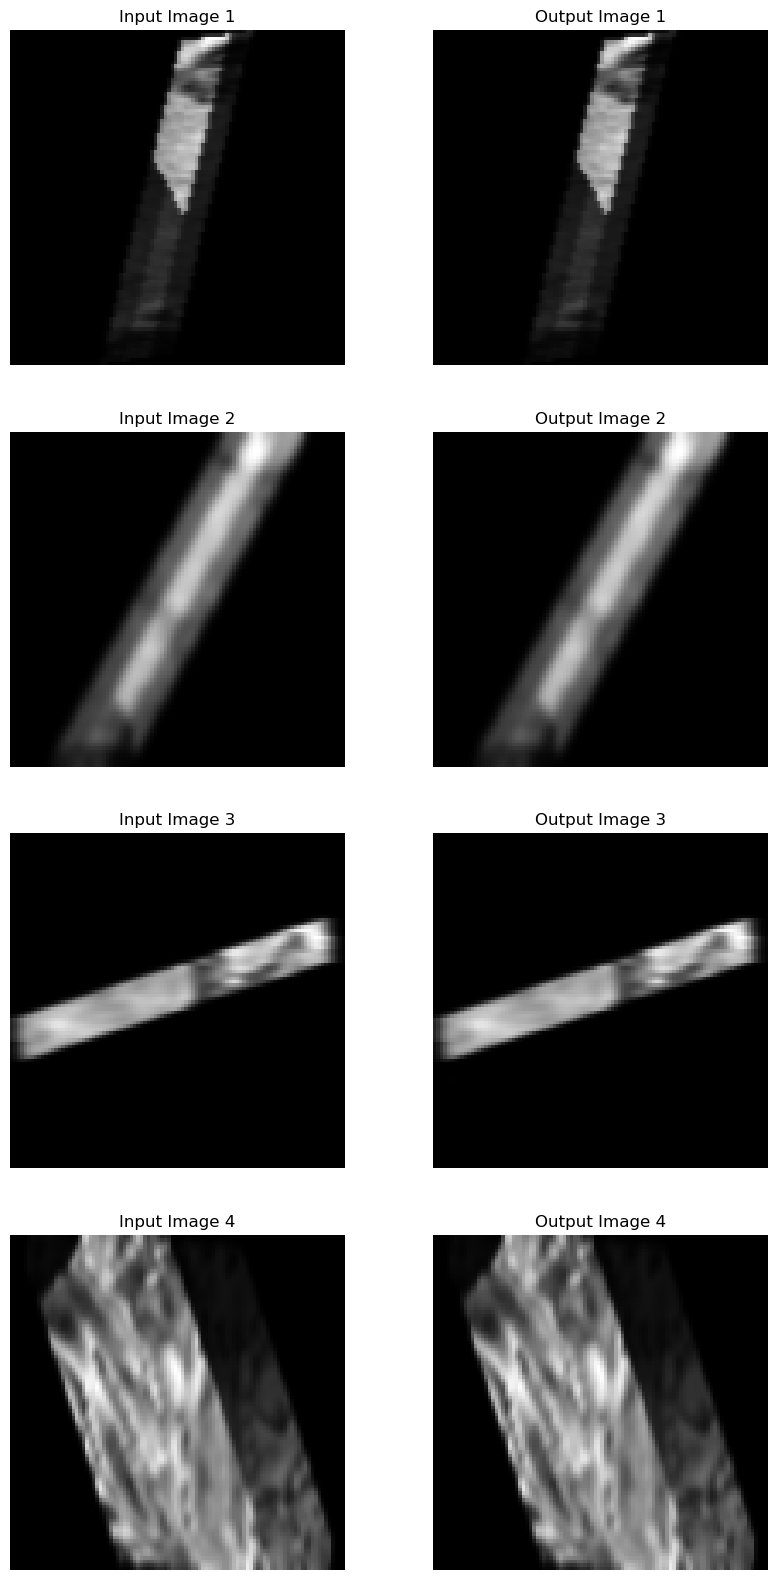

In [ ]:
import matplotlib.pyplot as plt

def show_images(inputs, outputs, n=4):
    """
    Function to visualize input and output images side by side.

    Parameters:
    - inputs (Tensor): The input images tensor of shape (B, C, D, H, W).
    - outputs (Tensor): The output images tensor of shape (B, C, D, H, W).
    - n (int): Number of images to display.
    """
    inputs = inputs.cpu().detach()
    outputs = outputs.cpu().detach()

    fig, axes = plt.subplots(n, 2, figsize=(10, n*5))
    
    for i in range(n):
        # Display the input image (choose the middle slice for visualization)
        axes[i, 0].imshow(inputs[i, 0, inputs.shape[2]//2], cmap='gray')
        axes[i, 0].set_title(f'Input Image {i+1}')
        axes[i, 0].axis('off')

        # Display the output image (choose the middle slice for visualization)
        axes[i, 1].imshow(outputs[i, 0, outputs.shape[2]//2], cmap='gray')
        axes[i, 1].set_title(f'Output Image {i+1}')
        axes[i, 1].axis('off')
    
    plt.show()

# Get a batch of data
images, labels = next(iter(train_loader))
images = images.to(device)

# Compute mask matrix
attn_mask = compute_mask(
    D=images.shape[2], 
    H=images.shape[3], 
    W=images.shape[4], 
    window_size=model.window_size, 
    shift_size=model.shift_size, 
    device=images.device
)

# Forward pass through the model
with torch.no_grad():
    outputs = model(images, attn_mask)

# Visualize the input and output images
show_images(images, outputs, n=4)
